In [193]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mne
import pandas as pd
from scipy.io import loadmat

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.linear_model import ElasticNetCV
from sklearn.model_selection import cross_val_score, GridSearchCV, LeaveOneOut
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import make_pipeline, Pipeline

from pyriemann.utils.mean import mean_covariance
from pyriemann.classification import MDM, FgMDM, TSclassifier
from pyriemann.estimation import Covariances
from pyriemann.tangentspace import TangentSpace

from mne.decoding import CSP
from tqdm.notebook import trange, tqdm


%matplotlib inline

In [131]:
l_freq, h_freq = 8, 30
start, stop = 3, 7.5
scoring = 'accuracy'

# Évaluation d'estimateurs Matlab/Python

In [152]:
path= "../../datasets/Clinical-Brain-Computer-Interfaces-Challenge-WCCI-2020-Glasgow/parsed_"
d = loadmat(path+"P01T.mat", squeeze_me=True)
Covs = Covariances(estimator='scm').fit_transform(d['RawEEGData'])
d['RawEEGData'].shape

(80, 12, 4096)

In [147]:
Covs[0]

array([[4812.86161565, 4311.77945639, 4193.04305322, 5197.15445978,
        5588.31747782, 5113.47602887, 5403.77736233, 5088.80685137,
        4976.65729833, 5331.23218989, 4649.73338412, 4487.33599467],
       [4311.77945639, 3894.24058806, 3771.75834666, 4705.83010614,
        5055.6038647 , 4623.67808889, 4883.53162133, 4618.4988672 ,
        4495.35642826, 4836.87660253, 4211.71813492, 4049.1837536 ],
       [4193.04305322, 3771.75834666, 3772.38269959, 4491.24022359,
        4854.16438512, 4410.63247858, 4704.80248915, 4324.35803575,
        4308.55593524, 4507.92920449, 3994.61338539, 3919.47647055],
       [5197.15445978, 4705.83010614, 4491.24022359, 5768.36880917,
        6182.06490011, 5654.2169617 , 5950.90608997, 5717.51000435,
        5476.36157613, 5992.90348398, 5173.81080237, 4906.26566697],
       [5588.31747782, 5055.6038647 , 4854.16438512, 6182.06490011,
        6638.58428747, 6058.46335547, 6390.10908199, 6107.8691408 ,
        5871.87388744, 6396.26319929, 5539.0

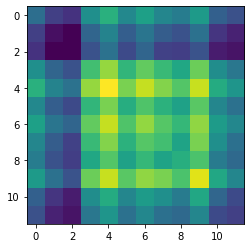

In [148]:
plt.imshow(Covs[0])

In [155]:
d = loadmat("MatFiltData_P01T_all.mat", squeeze_me=True)
data = np.transpose(d['MatFiltData'], axes=(2, 0, 1))
sfreq = 512
channel_names = ["F3", "FC3", "C3", "CP3", "P3", "FCz", "CPz", "F4", "FC4", "C4", "CP4", "P4"]
channel_types = 12 * ["eeg"]
montage = mne.channels.make_standard_montage('standard_1020')
info = mne.create_info(channel_names, sfreq, channel_types, montage)
tmin = 0.
event_id = {'right':1 , 'left':2}
events = np.array([[t*10*sfreq, 0, l] for t, l in enumerate(labels)])
epochs =  mne.EpochsArray(data, info, events, tmin, event_id)
epochs.set_montage(montage)

80 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


<ipython-input-155-1652b2505228>:7: DeprecationWarning: Passing montage to create_info is deprecated and will be removed in 0.21, use raw.set_montage (or epochs.set_montage, etc.) instead
  info = mne.create_info(channel_names, sfreq, channel_types, montage)


<EpochsArray  |   80 events (all good), 0 - 7.99805 sec, baseline off, ~30.0 MB, data loaded,
 'left': 40
 'right': 40>

In [165]:
d = loadmat("../../datasets/Clinical-Brain-Computer-Interfaces-Challenge-WCCI-2020-Glasgow/parsed_P01T.mat", squeeze_me=True)
data_orig = d['RawEEGData']
epochs_raw =  mne.EpochsArray(data_orig, info, events, tmin, event_id)
epochs_raw.set_montage(montage)

80 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


<EpochsArray  |   80 events (all good), 0 - 7.99805 sec, baseline off, ~30.0 MB, data loaded,
 'left': 40
 'right': 40>

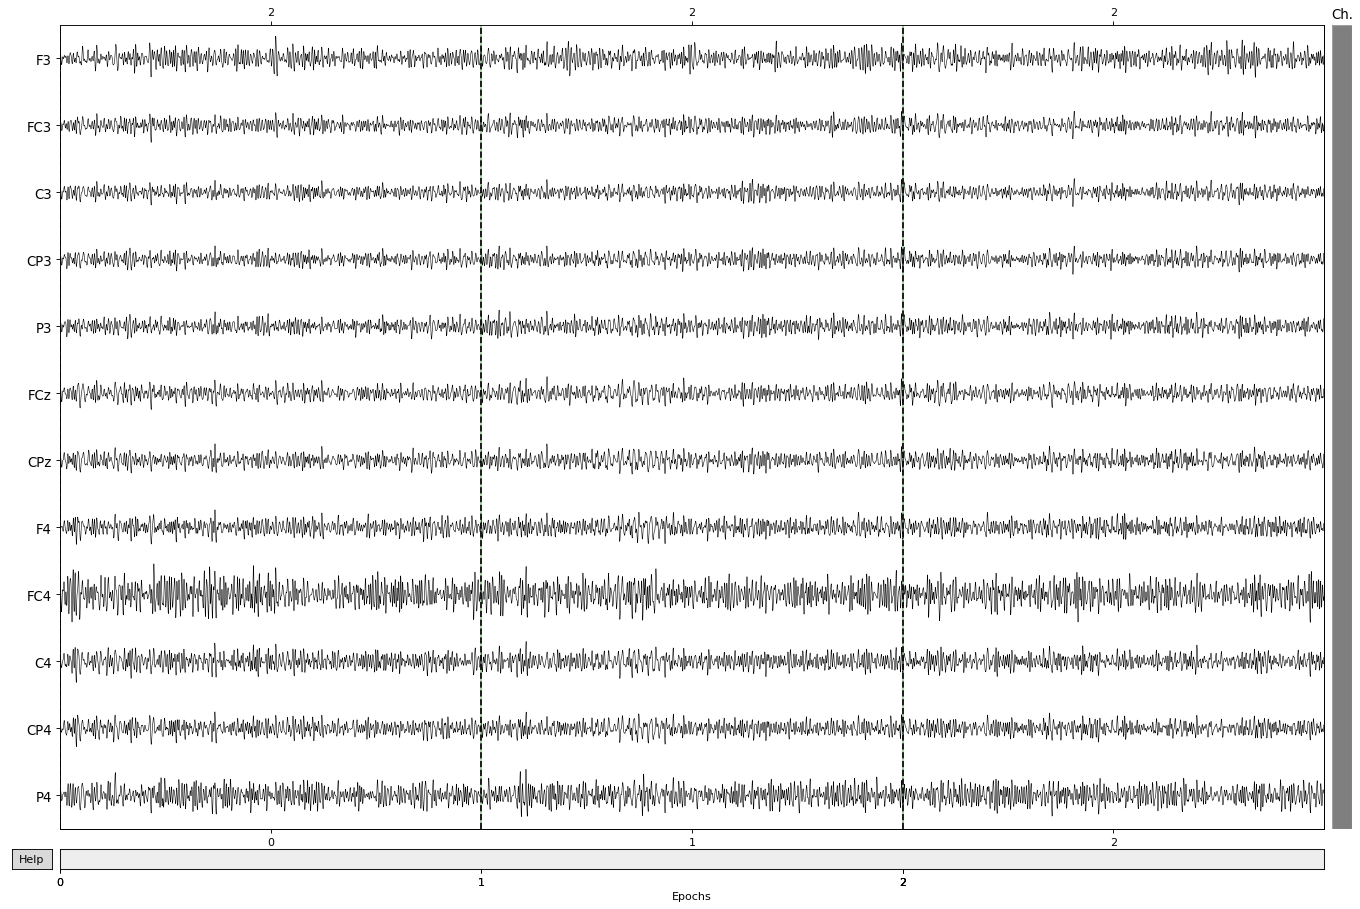

In [162]:
_ = epochs[:3].plot(scalings={'eeg':3e1})

Setting up band-pass filter from 8 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 8.00, 30.00 Hz: -6.02, -6.02 dB



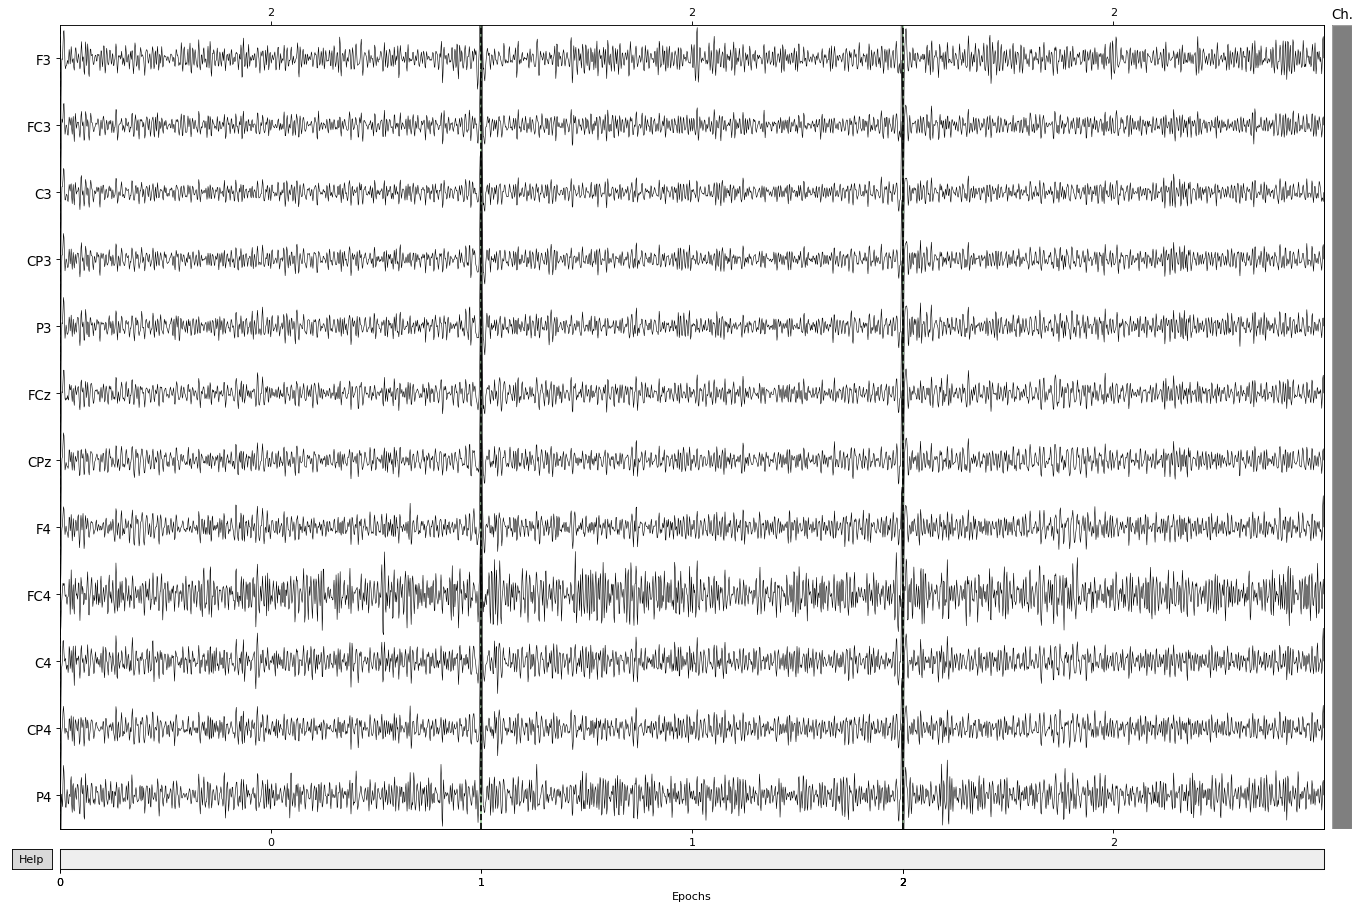

In [175]:
_ = epochs_raw[:3].copy().filter(l_freq=l_freq, h_freq=h_freq, method='iir').plot(scalings={'eeg':2e1})

Setting up band-pass filter from 8 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 8.00, 30.00 Hz: -6.02, -6.02 dB



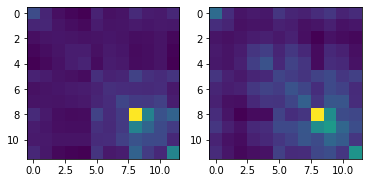

In [182]:
cov = Covariances(estimator='scm')
plt.subplot(1, 2, 1)
c_kaiser = cov.fit_transform(epochs[0].get_data())
plt.imshow(c_kaiser[0])
plt.subplot(1, 2, 2)
c_iir = cov.fit_transform(epochs_raw[0].copy().filter(l_freq=l_freq, h_freq=h_freq, method='iir').get_data())
plt.imshow(c_iir[0])

In [194]:
from pyriemann.utils.mean import mean_covariance
from pyriemann.utils.distance import distance

c_kaiser = cov.fit_transform(epochs.get_data())
c_iir = cov.fit_transform(epochs_raw.copy().filter(l_freq=l_freq, h_freq=h_freq, method='iir').get_data())
mk = mean_covariance(c_kaiser)
mi = mean_covariance(c_iir)
print ("dist mean-mean", distance(mk, mi, metric='riemann'))

md = []
for i in range(len(c_kaiser)):
    md.append(distance(c_kaiser[i], c_iir[i], metric='riemann'))
print ("average dist trial-trial", np.array(md).mean())

Setting up band-pass filter from 8 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 8.00, 30.00 Hz: -6.02, -6.02 dB

dist mean-mean 0.6415856037840434
average dist trial-trial 1.7784400901661683


In [200]:
obs_covs = np.concatenate((c_kaiser, c_iir))

obs_covs.shape

(160, 12, 12)

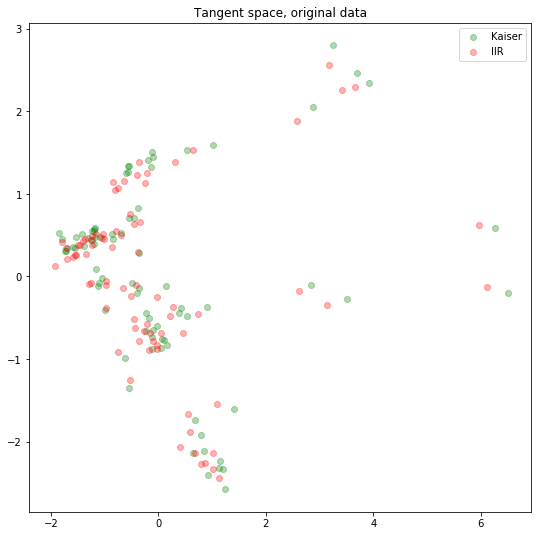

In [202]:
obs_covs = np.concatenate((c_kaiser, c_iir))
m = obs_covs.shape[0]
obs_mean = mean_covariance(obs_covs, metric='riemann')
ts = Pipeline([('mapping', TangentSpace(metric='riemann', tsupdate=False)),
               ('dim_reduc', PCA(n_components=2))])
ts.fit(obs_covs)

C_ts = ts.transform(obs_covs)

fig, ax = plt.subplots(1, 1, figsize=(9, 9))
ax.set_title("Tangent space, original data")
ax.scatter(C_ts[0:m//2, 0], C_ts[0:m//2, 1], c="g", alpha=0.3, label=r'Kaiser')
ax.scatter(C_ts[m//2:, 0], C_ts[m//2:, 1], c="r", alpha=0.3, label=r'IIR')
_ = ax.legend()
plt.show()


# Pipelines python

In [132]:
subjects = ["P{:02d}T".format(i) for i in range(1, 9)]
path= "../../datasets/Clinical-Brain-Computer-Interfaces-Challenge-WCCI-2020-Glasgow/parsed_"
sfreq = 512
channel_names = ["F3", "FC3", "C3", "CP3", "P3", "FCz", "CPz", "F4", "FC4", "C4", "CP4", "P4"]
channel_types = 12 * ["eeg"]
montage = mne.channels.make_standard_montage('standard_1020')
info = mne.create_info(channel_names, sfreq, channel_types, montage)
tmin = 0.
event_id = {'right':1 , 'left':2}

ep = []
#ep_y = []
for s in subjects:
    d = loadmat(path+s+".mat", squeeze_me=True)
    labels = d['Labels']
    data = d['RawEEGData']
    events = np.array([[t*10*sfreq, 0, l] for t, l in enumerate(labels)])
    epochs =  mne.EpochsArray(data, info, events, tmin, event_id)
    epochs.set_montage(montage)
    # epochs.filter(l_freq=l_freq, h_freq=h_freq, fir_design='firwin2', method='fir')
    epochs.filter(l_freq=l_freq, h_freq=h_freq, method='iir')
    epochs.crop(tmin=start, tmax=stop)
    ep.append(epochs)
    #ep_y.append(labels)

80 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
Setting up band-pass filter from 8 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 8.00, 30.00 Hz: -6.02, -6.02 dB



<ipython-input-132-6caf7e833021>:7: DeprecationWarning: Passing montage to create_info is deprecated and will be removed in 0.21, use raw.set_montage (or epochs.set_montage, etc.) instead
  info = mne.create_info(channel_names, sfreq, channel_types, montage)


80 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
Setting up band-pass filter from 8 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 8.00, 30.00 Hz: -6.02, -6.02 dB

80 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
Setting up band-pass filter from 8 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 8.00, 30.00 Hz: -6.02, -6.02 dB

80 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
Setting up band-pass filter from 8 - 30 Hz

IIR filter parameters
-------------

In [112]:
ep[0]

<EpochsArray  |   80 events (all good), 3.5 - 7.99805 sec, baseline off, ~16.9 MB, data loaded,
 'left': 40
 'right': 40>

In [133]:
param_svc = {'C': np.logspace(-2, 2, 10)}
gssvc = GridSearchCV(SVC(kernel='linear'), param_svc, cv=3)
param_elasticnet = {'1_ratio': 1 - np.logspace(-2, 0, 10),
                    'cv': 3}
elasticnetcv = ElasticNetCV(*param_elasticnet)

pipelines = {}
pipelines['MDM'] = make_pipeline(
    Covariances(estimator='scm'),
    MDM(metric='riemann', n_jobs=-1))
pipelines['fgMDM'] = make_pipeline(
    Covariances(estimator='scm'),
    FgMDM(metric='riemann', tsupdate=False, n_jobs=-1))
pipelines['TS_SVM'] = make_pipeline(
    Covariances(estimator='scm'),
    TangentSpace(metric='riemann'),
    gssvc)
#pipelines['TS_GLM'] = make_pipeline(
#    Covariances(estimator='lwf'),
#    TangentSpace(metric='riemann'),
#    elasticnetcv)

pipelines['CSP_LDA'] = make_pipeline(
    CSP(n_components=6), 
    LDA())
pipelines['CSP_SVM'] = make_pipeline(
    CSP(n_components=6), 
    gssvc)
#pipelines['CSP_GLM'] = make_pipeline(
#    CSP(n_components=6), 
#    elasticnetcv)

In [134]:
cv = LeaveOneOut()
all_res = []
for i, s in enumerate(tqdm(subjects)):
    print (s)
    X = ep[i].get_data()
    y = epochs.events[:,-1]
    le = LabelEncoder()
    y = le.fit_transform(y)

    for name in tqdm(pipelines):
        acc = cross_val_score(pipelines[name], X, y, cv=cv, scoring=scoring)
        res = {'subject': str(s),
               'score': acc.mean(),
               'pipeline': name}
        all_res.append(res)
df_std = pd.DataFrame(all_res)

P01T


Computing rank from data with rank=None
    Using tolerance 11 (2.2e-16 eps * 12 dim * 4.1e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 12 (2.2e-16 eps * 12 dim * 4.5e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 11 (2.2e-16 eps * 12 dim * 4.1e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 12 (2.2e-16 eps * 12 dim * 4.5e+15  max singular value)
    Estimated rank (

    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 12 (2.2e-16 eps * 12 dim * 4.5e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 11 (2.2e-16 eps * 12 dim * 4e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 12 (2.2e-16 eps * 12 dim * 4.5e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
D

Done.
Computing rank from data with rank=None
    Using tolerance 12 (2.2e-16 eps * 12 dim * 4.5e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 11 (2.2e-16 eps * 12 dim * 4.1e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 12 (2.2e-16 eps * 12 dim * 4.5e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 11 (2.2e-16 eps * 12 dim * 4.1e+15  max singular value)
    Estimated 

    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 11 (2.2e-16 eps * 12 dim * 4.1e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 12 (2.2e-16 eps * 12 dim * 4.4e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 11 (2.2e-16 eps * 12 dim * 4.1e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL

Computing rank from data with rank=None
    Using tolerance 11 (2.2e-16 eps * 12 dim * 4e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 12 (2.2e-16 eps * 12 dim * 4.5e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 11 (2.2e-16 eps * 12 dim * 4e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 12 (2.2e-16 eps * 12 dim * 4.5e+15  max singular value)
    Estimated rank (mag)

    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 12 (2.2e-16 eps * 12 dim * 4.5e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 11 (2.2e-16 eps * 12 dim * 4.1e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 12 (2.2e-16 eps * 12 dim * 4.5e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL

Done.
Computing rank from data with rank=None
    Using tolerance 12 (2.2e-16 eps * 12 dim * 4.5e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 11 (2.2e-16 eps * 12 dim * 4.1e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 12 (2.2e-16 eps * 12 dim * 4.5e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 11 (2.2e-16 eps * 12 dim * 4.1e+15  max singular value)
    Estimated 

    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 11 (2.2e-16 eps * 12 dim * 4.1e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 12 (2.2e-16 eps * 12 dim * 4.5e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 11 (2.2e-16 eps * 12 dim * 4.1e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL

Done.
Computing rank from data with rank=None
    Using tolerance 11 (2.2e-16 eps * 12 dim * 4.1e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 12 (2.2e-16 eps * 12 dim * 4.5e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 11 (2.2e-16 eps * 12 dim * 4.1e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 12 (2.2e-16 eps * 12 dim * 4.5e+15  max singular value)
    Estimated 

    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 12 (2.2e-16 eps * 12 dim * 4.4e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 11 (2.2e-16 eps * 12 dim * 4.1e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 12 (2.2e-16 eps * 12 dim * 4.4e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL

    Using tolerance 12 (2.2e-16 eps * 12 dim * 4.5e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 11 (2.2e-16 eps * 12 dim * 4.1e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 11 (2.2e-16 eps * 12 dim * 4e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 11 (2.2e-16 eps * 12 dim * 4.1e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12

Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 11 (2.2e-16 eps * 12 dim * 4.1e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 12 (2.2e-16 eps * 12 dim * 4.5e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 11 (2.2e-16 eps * 12 dim * 4.1e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance

Computing rank from data with rank=None
    Using tolerance 10 (2.2e-16 eps * 12 dim * 3.8e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 10 (2.2e-16 eps * 12 dim * 3.7e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 10 (2.2e-16 eps * 12 dim * 3.8e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 9.9 (2.2e-16 eps * 12 dim * 3.7e+15  max singular value)
    Estimated rank 

    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 10 (2.2e-16 eps * 12 dim * 3.8e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 10 (2.2e-16 eps * 12 dim * 3.8e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 10 (2.2e-16 eps * 12 dim * 3.8e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL

Done.
Computing rank from data with rank=None
    Using tolerance 9.9 (2.2e-16 eps * 12 dim * 3.7e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 10 (2.2e-16 eps * 12 dim * 3.8e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 9.9 (2.2e-16 eps * 12 dim * 3.7e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 9.9 (2.2e-16 eps * 12 dim * 3.7e+15  max singular value)
    Estimat

    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 10 (2.2e-16 eps * 12 dim * 3.8e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 10 (2.2e-16 eps * 12 dim * 3.7e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 10 (2.2e-16 eps * 12 dim * 3.8e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL

Done.
Computing rank from data with rank=None
    Using tolerance 10 (2.2e-16 eps * 12 dim * 3.7e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 10 (2.2e-16 eps * 12 dim * 3.8e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 10 (2.2e-16 eps * 12 dim * 3.8e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 10 (2.2e-16 eps * 12 dim * 3.8e+15  max singular value)
    Estimated 

    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 10 (2.2e-16 eps * 12 dim * 3.8e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 10 (2.2e-16 eps * 12 dim * 3.8e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 10 (2.2e-16 eps * 12 dim * 3.8e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL

Done.
Computing rank from data with rank=None
    Using tolerance 10 (2.2e-16 eps * 12 dim * 3.7e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 10 (2.2e-16 eps * 12 dim * 3.8e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 10 (2.2e-16 eps * 12 dim * 3.8e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 10 (2.2e-16 eps * 12 dim * 3.8e+15  max singular value)
    Estimated 

    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 10 (2.2e-16 eps * 12 dim * 3.8e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 9.9 (2.2e-16 eps * 12 dim * 3.7e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 10 (2.2e-16 eps * 12 dim * 3.8e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICA

Done.
Computing rank from data with rank=None
    Using tolerance 10 (2.2e-16 eps * 12 dim * 3.8e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 10 (2.2e-16 eps * 12 dim * 3.8e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 10 (2.2e-16 eps * 12 dim * 3.8e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 10 (2.2e-16 eps * 12 dim * 3.8e+15  max singular value)
    Estimated 

    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 10 (2.2e-16 eps * 12 dim * 3.7e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 10 (2.2e-16 eps * 12 dim * 3.8e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 10 (2.2e-16 eps * 12 dim * 3.7e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL

Done.
Computing rank from data with rank=None
    Using tolerance 10 (2.2e-16 eps * 12 dim * 3.7e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 10 (2.2e-16 eps * 12 dim * 3.8e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 10 (2.2e-16 eps * 12 dim * 3.7e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 10 (2.2e-16 eps * 12 dim * 3.8e+15  max singular value)
    Estimated 

    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 10 (2.2e-16 eps * 12 dim * 3.8e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 10 (2.2e-16 eps * 12 dim * 3.8e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 10 (2.2e-16 eps * 12 dim * 3.8e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL

Computing rank from data with rank=None
    Using tolerance 22 (2.2e-16 eps * 12 dim * 8.2e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 14 (2.2e-16 eps * 12 dim * 5.4e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 22 (2.2e-16 eps * 12 dim * 8.2e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 29 (2.2e-16 eps * 12 dim * 1.1e+16  max singular value)
    Estimated rank (

    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 30 (2.2e-16 eps * 12 dim * 1.1e+16  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 22 (2.2e-16 eps * 12 dim * 8.2e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 30 (2.2e-16 eps * 12 dim * 1.1e+16  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL

Done.
Computing rank from data with rank=None
    Using tolerance 30 (2.2e-16 eps * 12 dim * 1.1e+16  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 22 (2.2e-16 eps * 12 dim * 8.2e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 29 (2.2e-16 eps * 12 dim * 1.1e+16  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 22 (2.2e-16 eps * 12 dim * 8.2e+15  max singular value)
    Estimated 

    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 22 (2.2e-16 eps * 12 dim * 8.2e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 30 (2.2e-16 eps * 12 dim * 1.1e+16  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 22 (2.2e-16 eps * 12 dim * 8.2e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL

Done.
Computing rank from data with rank=None
    Using tolerance 22 (2.2e-16 eps * 12 dim * 8.2e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 30 (2.2e-16 eps * 12 dim * 1.1e+16  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 22 (2.2e-16 eps * 12 dim * 8.2e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 30 (2.2e-16 eps * 12 dim * 1.1e+16  max singular value)
    Estimated 

    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 30 (2.2e-16 eps * 12 dim * 1.1e+16  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 22 (2.2e-16 eps * 12 dim * 8.2e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 30 (2.2e-16 eps * 12 dim * 1.1e+16  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL

Done.
Computing rank from data with rank=None
    Using tolerance 29 (2.2e-16 eps * 12 dim * 1.1e+16  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 22 (2.2e-16 eps * 12 dim * 8.2e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 30 (2.2e-16 eps * 12 dim * 1.1e+16  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 22 (2.2e-16 eps * 12 dim * 8.2e+15  max singular value)
    Estimated 

    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 22 (2.2e-16 eps * 12 dim * 8.2e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 30 (2.2e-16 eps * 12 dim * 1.1e+16  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 22 (2.2e-16 eps * 12 dim * 8.2e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL

Done.
Computing rank from data with rank=None
    Using tolerance 22 (2.2e-16 eps * 12 dim * 8.2e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 30 (2.2e-16 eps * 12 dim * 1.1e+16  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 22 (2.2e-16 eps * 12 dim * 8.2e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 30 (2.2e-16 eps * 12 dim * 1.1e+16  max singular value)
    Estimated 

    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 30 (2.2e-16 eps * 12 dim * 1.1e+16  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 22 (2.2e-16 eps * 12 dim * 8.2e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 30 (2.2e-16 eps * 12 dim * 1.1e+16  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL

Done.
Computing rank from data with rank=None
    Using tolerance 30 (2.2e-16 eps * 12 dim * 1.1e+16  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 22 (2.2e-16 eps * 12 dim * 8.2e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 30 (2.2e-16 eps * 12 dim * 1.1e+16  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 22 (2.2e-16 eps * 12 dim * 8.2e+15  max singular value)
    Estimated 

    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 22 (2.2e-16 eps * 12 dim * 8.2e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 30 (2.2e-16 eps * 12 dim * 1.1e+16  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 22 (2.2e-16 eps * 12 dim * 8.2e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL

Computing rank from data with rank=None
    Using tolerance 9.3 (2.2e-16 eps * 12 dim * 3.5e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 8.9 (2.2e-16 eps * 12 dim * 3.3e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 9.3 (2.2e-16 eps * 12 dim * 3.5e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 8.9 (2.2e-16 eps * 12 dim * 3.3e+15  max singular value)
    Estimated ra

    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 9 (2.2e-16 eps * 12 dim * 3.4e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 9.2 (2.2e-16 eps * 12 dim * 3.4e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 9 (2.2e-16 eps * 12 dim * 3.4e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimatin

Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 8.9 (2.2e-16 eps * 12 dim * 3.4e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 9.3 (2.2e-16 eps * 12 dim * 3.5e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 8.9 (2.2e-16 eps * 12 dim * 3.3e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 9.2 (2.2e-16 eps * 12 dim * 3

    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 9.3 (2.2e-16 eps * 12 dim * 3.5e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 8.9 (2.2e-16 eps * 12 dim * 3.3e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 9.3 (2.2e-16 eps * 12 dim * 3.5e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estim

Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 9.2 (2.2e-16 eps * 12 dim * 3.5e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 9 (2.2e-16 eps * 12 dim * 3.4e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 9.2 (2.2e-16 eps * 12 dim * 3.5e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 9 (2.2e-16 eps * 12 dim * 3.4e+

    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 9 (2.2e-16 eps * 12 dim * 3.4e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 9.2 (2.2e-16 eps * 12 dim * 3.5e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 9 (2.2e-16 eps * 12 dim * 3.4e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimatin

Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 8.9 (2.2e-16 eps * 12 dim * 3.3e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 9.3 (2.2e-16 eps * 12 dim * 3.5e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 8.9 (2.2e-16 eps * 12 dim * 3.3e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 9.3 (2.2e-16 eps * 12 dim * 3

    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 9.3 (2.2e-16 eps * 12 dim * 3.5e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 8.9 (2.2e-16 eps * 12 dim * 3.3e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 9.3 (2.2e-16 eps * 12 dim * 3.5e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estim

Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 9.2 (2.2e-16 eps * 12 dim * 3.5e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 9 (2.2e-16 eps * 12 dim * 3.4e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 9.3 (2.2e-16 eps * 12 dim * 3.5e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 9 (2.2e-16 eps * 12 dim * 3.4e+

    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 8.9 (2.2e-16 eps * 12 dim * 3.3e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 9.3 (2.2e-16 eps * 12 dim * 3.5e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 8.9 (2.2e-16 eps * 12 dim * 3.4e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estim

Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 8.9 (2.2e-16 eps * 12 dim * 3.4e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 9.3 (2.2e-16 eps * 12 dim * 3.5e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 8.9 (2.2e-16 eps * 12 dim * 3.4e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 9.3 (2.2e-16 eps * 12 dim * 3

    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 9.2 (2.2e-16 eps * 12 dim * 3.5e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 9 (2.2e-16 eps * 12 dim * 3.4e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 9.2 (2.2e-16 eps * 12 dim * 3.5e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimat

Computing rank from data with rank=None
    Using tolerance 13 (2.2e-16 eps * 12 dim * 4.7e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 13 (2.2e-16 eps * 12 dim * 4.8e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 13 (2.2e-16 eps * 12 dim * 4.7e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 13 (2.2e-16 eps * 12 dim * 4.8e+15  max singular value)
    Estimated rank (

    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 13 (2.2e-16 eps * 12 dim * 4.8e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 13 (2.2e-16 eps * 12 dim * 4.7e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 13 (2.2e-16 eps * 12 dim * 4.8e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL

Done.
Computing rank from data with rank=None
    Using tolerance 13 (2.2e-16 eps * 12 dim * 4.8e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 13 (2.2e-16 eps * 12 dim * 4.7e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 13 (2.2e-16 eps * 12 dim * 4.8e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 13 (2.2e-16 eps * 12 dim * 4.7e+15  max singular value)
    Estimated 

    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 13 (2.2e-16 eps * 12 dim * 4.7e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 13 (2.2e-16 eps * 12 dim * 4.8e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 13 (2.2e-16 eps * 12 dim * 4.7e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL

Done.
Computing rank from data with rank=None
    Using tolerance 12 (2.2e-16 eps * 12 dim * 4.7e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 13 (2.2e-16 eps * 12 dim * 4.8e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 13 (2.2e-16 eps * 12 dim * 4.7e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 13 (2.2e-16 eps * 12 dim * 4.8e+15  max singular value)
    Estimated 

    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 13 (2.2e-16 eps * 12 dim * 4.8e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 13 (2.2e-16 eps * 12 dim * 4.7e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 13 (2.2e-16 eps * 12 dim * 4.8e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL

Done.
Computing rank from data with rank=None
    Using tolerance 13 (2.2e-16 eps * 12 dim * 4.8e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 13 (2.2e-16 eps * 12 dim * 4.7e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 13 (2.2e-16 eps * 12 dim * 4.8e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 13 (2.2e-16 eps * 12 dim * 4.7e+15  max singular value)
    Estimated 

    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 13 (2.2e-16 eps * 12 dim * 4.7e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 13 (2.2e-16 eps * 12 dim * 4.7e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 13 (2.2e-16 eps * 12 dim * 4.7e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL

Done.
Computing rank from data with rank=None
    Using tolerance 12 (2.2e-16 eps * 12 dim * 4.7e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 13 (2.2e-16 eps * 12 dim * 4.8e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 12 (2.2e-16 eps * 12 dim * 4.7e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 13 (2.2e-16 eps * 12 dim * 4.8e+15  max singular value)
    Estimated 

    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 13 (2.2e-16 eps * 12 dim * 4.8e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 13 (2.2e-16 eps * 12 dim * 4.7e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 13 (2.2e-16 eps * 12 dim * 4.8e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL

Done.
Computing rank from data with rank=None
    Using tolerance 13 (2.2e-16 eps * 12 dim * 4.8e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 13 (2.2e-16 eps * 12 dim * 4.7e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 13 (2.2e-16 eps * 12 dim * 4.8e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 13 (2.2e-16 eps * 12 dim * 4.7e+15  max singular value)
    Estimated 

    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 13 (2.2e-16 eps * 12 dim * 4.7e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 13 (2.2e-16 eps * 12 dim * 4.8e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 13 (2.2e-16 eps * 12 dim * 4.7e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL

Computing rank from data with rank=None
    Using tolerance 11 (2.2e-16 eps * 12 dim * 4e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 11 (2.2e-16 eps * 12 dim * 4e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 11 (2.2e-16 eps * 12 dim * 4e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 11 (2.2e-16 eps * 12 dim * 4e+15  max singular value)
    Estimated rank (mag): 12

Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 11 (2.2e-16 eps * 12 dim * 4.1e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 10 (2.2e-16 eps * 12 dim * 3.9e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 11 (2.2e-16 eps * 12 dim * 4.1e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance

    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 11 (2.2e-16 eps * 12 dim * 4e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 11 (2.2e-16 eps * 12 dim * 4e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 10 (2.2e-16 eps * 12 dim * 3.9e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating c

Done.
Computing rank from data with rank=None
    Using tolerance 11 (2.2e-16 eps * 12 dim * 4e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 11 (2.2e-16 eps * 12 dim * 4e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 11 (2.2e-16 eps * 12 dim * 4e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 11 (2.2e-16 eps * 12 dim * 4e+15  max singular value)
    Estimated rank (ma

Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 11 (2.2e-16 eps * 12 dim * 4.1e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 10 (2.2e-16 eps * 12 dim * 3.9e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 11 (2.2e-16 eps * 12 dim * 4.1e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance

    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 10 (2.2e-16 eps * 12 dim * 3.9e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 11 (2.2e-16 eps * 12 dim * 4.1e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 10 (2.2e-16 eps * 12 dim * 3.9e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimati

Done.
Computing rank from data with rank=None
    Using tolerance 11 (2.2e-16 eps * 12 dim * 4e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 11 (2.2e-16 eps * 12 dim * 4e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 11 (2.2e-16 eps * 12 dim * 4e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 11 (2.2e-16 eps * 12 dim * 4e+15  max singular value)
    Estimated rank (ma

    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 11 (2.2e-16 eps * 12 dim * 4e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 11 (2.2e-16 eps * 12 dim * 4e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 11 (2.2e-16 eps * 12 dim * 4e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.

    Using tolerance 11 (2.2e-16 eps * 12 dim * 4.1e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 10 (2.2e-16 eps * 12 dim * 3.9e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 11 (2.2e-16 eps * 12 dim * 4.1e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 10 (2.2e-16 eps * 12 dim * 3.9e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 

Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 11 (2.2e-16 eps * 12 dim * 4e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 11 (2.2e-16 eps * 12 dim * 4e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 10 (2.2e-16 eps * 12 dim * 3.9e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 11 

    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 11 (2.2e-16 eps * 12 dim * 4e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 11 (2.2e-16 eps * 12 dim * 4e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 11 (2.2e-16 eps * 12 dim * 4e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating cov

Done.
Computing rank from data with rank=None
    Using tolerance 11 (2.2e-16 eps * 12 dim * 4.1e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 10 (2.2e-16 eps * 12 dim * 3.9e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 11 (2.2e-16 eps * 12 dim * 4.1e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 10 (2.2e-16 eps * 12 dim * 3.9e+15  max singular value)
    Estimated 

Computing rank from data with rank=None
    Using tolerance 9.7 (2.2e-16 eps * 12 dim * 3.6e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 11 (2.2e-16 eps * 12 dim * 4.2e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 9.7 (2.2e-16 eps * 12 dim * 3.6e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 11 (2.2e-16 eps * 12 dim * 4.2e+15  max singular value)
    Estimated rank

    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 11 (2.2e-16 eps * 12 dim * 4.2e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 9.6 (2.2e-16 eps * 12 dim * 3.6e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 11 (2.2e-16 eps * 12 dim * 4.2e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimat

Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 11 (2.2e-16 eps * 12 dim * 4.2e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 9.7 (2.2e-16 eps * 12 dim * 3.6e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 11 (2.2e-16 eps * 12 dim * 4.2e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 9.5 (2.2e-16 eps * 12 dim * 3.6

    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 9.7 (2.2e-16 eps * 12 dim * 3.6e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 11 (2.2e-16 eps * 12 dim * 4.2e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 9.7 (2.2e-16 eps * 12 dim * 3.6e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estima

Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 9.6 (2.2e-16 eps * 12 dim * 3.6e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 11 (2.2e-16 eps * 12 dim * 4.2e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 9.6 (2.2e-16 eps * 12 dim * 3.6e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 11 (2.2e-16 eps * 12 dim * 4.2

    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 11 (2.2e-16 eps * 12 dim * 4.2e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 9.6 (2.2e-16 eps * 12 dim * 3.6e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 11 (2.2e-16 eps * 12 dim * 4.2e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimat

Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 11 (2.2e-16 eps * 12 dim * 4.2e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 9.7 (2.2e-16 eps * 12 dim * 3.6e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 11 (2.2e-16 eps * 12 dim * 4.2e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 9.7 (2.2e-16 eps * 12 dim * 3.6

    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 9.7 (2.2e-16 eps * 12 dim * 3.6e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 11 (2.2e-16 eps * 12 dim * 4.1e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 9.7 (2.2e-16 eps * 12 dim * 3.6e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estima

Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 9.6 (2.2e-16 eps * 12 dim * 3.6e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 11 (2.2e-16 eps * 12 dim * 4.2e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 9.6 (2.2e-16 eps * 12 dim * 3.6e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 11 (2.2e-16 eps * 12 dim * 4.2

    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 11 (2.2e-16 eps * 12 dim * 4.2e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 9.7 (2.2e-16 eps * 12 dim * 3.6e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 11 (2.2e-16 eps * 12 dim * 4.2e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimat

Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 11 (2.2e-16 eps * 12 dim * 4.2e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 9.7 (2.2e-16 eps * 12 dim * 3.6e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 11 (2.2e-16 eps * 12 dim * 4.2e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 9.7 (2.2e-16 eps * 12 dim * 3.6

    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 9.6 (2.2e-16 eps * 12 dim * 3.6e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 11 (2.2e-16 eps * 12 dim * 4.2e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 9.6 (2.2e-16 eps * 12 dim * 3.6e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estima

Computing rank from data with rank=None
    Using tolerance 9.8 (2.2e-16 eps * 12 dim * 3.7e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 10 (2.2e-16 eps * 12 dim * 3.9e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 9.8 (2.2e-16 eps * 12 dim * 3.7e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 11 (2.2e-16 eps * 12 dim * 3.9e+15  max singular value)
    Estimated rank

    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 11 (2.2e-16 eps * 12 dim * 4e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 9.7 (2.2e-16 eps * 12 dim * 3.6e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 11 (2.2e-16 eps * 12 dim * 4e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Do

Done.
Computing rank from data with rank=None
    Using tolerance 11 (2.2e-16 eps * 12 dim * 3.9e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 9.8 (2.2e-16 eps * 12 dim * 3.7e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 10 (2.2e-16 eps * 12 dim * 3.9e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 9.6 (2.2e-16 eps * 12 dim * 3.6e+15  max singular value)
    Estimate

    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 9.8 (2.2e-16 eps * 12 dim * 3.7e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 10 (2.2e-16 eps * 12 dim * 3.9e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 9.8 (2.2e-16 eps * 12 dim * 3.7e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRIC

Computing rank from data with rank=None
    Using tolerance 9.6 (2.2e-16 eps * 12 dim * 3.6e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 11 (2.2e-16 eps * 12 dim * 4e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 9.6 (2.2e-16 eps * 12 dim * 3.6e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 11 (2.2e-16 eps * 12 dim * 4e+15  max singular value)
    Estimated rank (ma

    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 11 (2.2e-16 eps * 12 dim * 4e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 9.6 (2.2e-16 eps * 12 dim * 3.6e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 11 (2.2e-16 eps * 12 dim * 4e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Do

Done.
Computing rank from data with rank=None
    Using tolerance 11 (2.2e-16 eps * 12 dim * 3.9e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 9.8 (2.2e-16 eps * 12 dim * 3.7e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 11 (2.2e-16 eps * 12 dim * 4e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 9.8 (2.2e-16 eps * 12 dim * 3.7e+15  max singular value)
    Estimated 

    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 9.8 (2.2e-16 eps * 12 dim * 3.7e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 11 (2.2e-16 eps * 12 dim * 3.9e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 9.8 (2.2e-16 eps * 12 dim * 3.7e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRIC

Done.
Computing rank from data with rank=None
    Using tolerance 9.6 (2.2e-16 eps * 12 dim * 3.6e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 11 (2.2e-16 eps * 12 dim * 4e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 9.6 (2.2e-16 eps * 12 dim * 3.6e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 11 (2.2e-16 eps * 12 dim * 4e+15  max singular value)
    Estimated ra

    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 11 (2.2e-16 eps * 12 dim * 4e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 9.8 (2.2e-16 eps * 12 dim * 3.7e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 11 (2.2e-16 eps * 12 dim * 4e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Do

Computing rank from data with rank=None
    Using tolerance 11 (2.2e-16 eps * 12 dim * 4e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 9.8 (2.2e-16 eps * 12 dim * 3.7e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 11 (2.2e-16 eps * 12 dim * 4e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 9.8 (2.2e-16 eps * 12 dim * 3.7e+15  max singular value)
    Estimated rank (ma

    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 9.7 (2.2e-16 eps * 12 dim * 3.6e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 11 (2.2e-16 eps * 12 dim * 4e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 9.6 (2.2e-16 eps * 12 dim * 3.6e+15  max singular value)
    Estimated rank (mag): 12
    MAG: rank 12 computed from 12 data channels with 0 projectors
Reducing data rank from 12 -> 12
Estimating covariance using EMPIRICAL

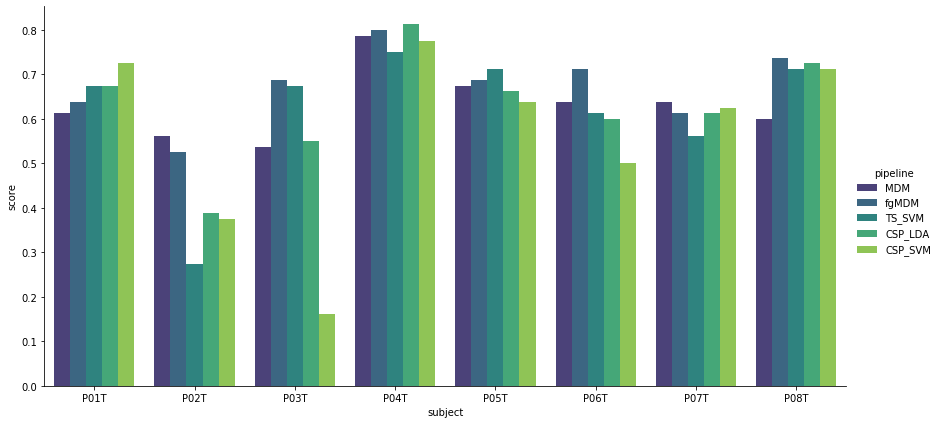

In [137]:
sns.catplot(x='subject', y='score', hue='pipeline', kind='bar', data=df_std, height=6, aspect=2, palette="viridis")
plt.savefig("covariance-subject.png")

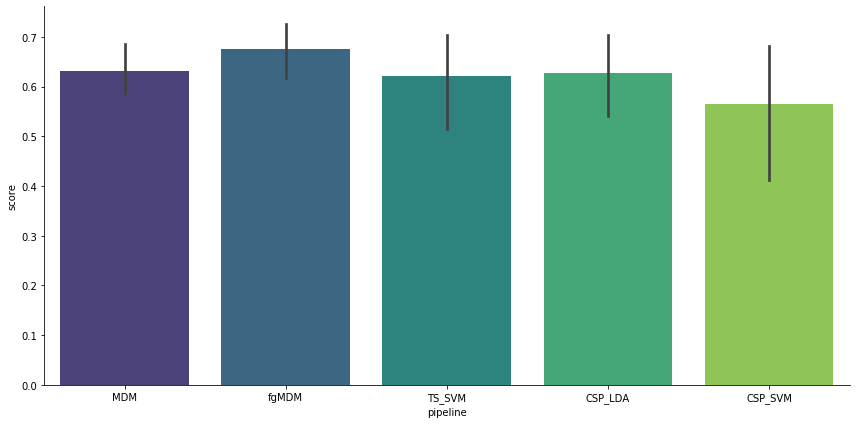

In [138]:
sns.catplot(x='pipeline', y='score', kind='bar', data=df_std, height=6, aspect=2, palette="viridis")
plt.savefig("covariance-classif.png")

In [116]:
df_std[df_std['pipeline'] == "fgMDM"]["score"].to_numpy()

array([0.725 , 0.625 , 0.6375, 0.8   , 0.6875, 0.7125, 0.6375, 0.8125])

In [139]:
df_std[df_std['pipeline'] == "fgMDM"]["score"].to_numpy().mean()

0.675

# Predict

# Todo

Try GLMnet